<a href="https://colab.research.google.com/github/lim-ye-ji/-/blob/yeji/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
import PIL.Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from keras.models import Sequential, load_model

import cv2

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/dacon_수화이미지분류/data_train_class/'
data_dir = pathlib.Path(data_dir)

In [ ]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

10597


In [ ]:
batch_size = 64
img_height = 96
img_width = 96

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split = 0.25,
  subset = "training",
  seed = 123,
  image_size = [img_height, img_width],
  batch_size = batch_size)

Found 10597 files belonging to 11 classes.
Using 7948 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split = 0.25,
  subset = "validation",
  seed = 123,
  image_size = [img_height, img_width],
  batch_size = batch_size)

Found 10597 files belonging to 11 classes.
Using 2649 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)
class_count = len(class_names)
print(class_count)

['1', '10-1', '10-2', '2', '3', '4', '5', '6', '7', '8', '9']
11


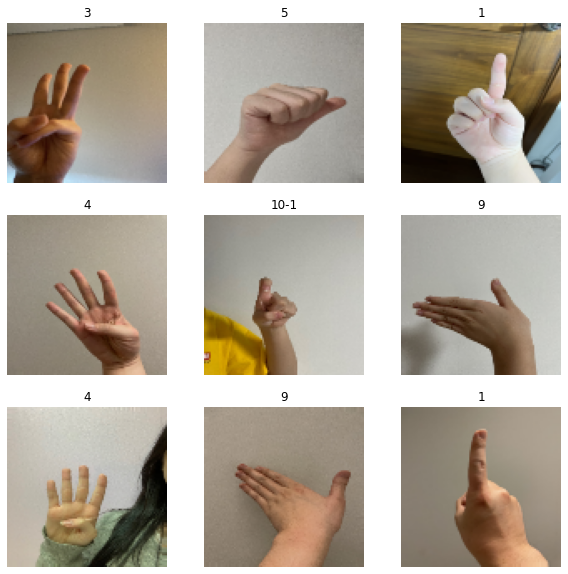

In [ ]:
plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
'''
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))
'''

'\nAUTOTUNE = tf.data.experimental.AUTOTUNE\n\ntrain_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)\nval_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)\n\nnormalization_layer = layers.experimental.preprocessing.Rescaling(1./255)\n\nnormalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))\nimage_batch, labels_batch = next(iter(normalized_ds))\nfirst_image = image_batch[0]\n\nprint(np.min(first_image), np.max(first_image))\n'

In [ ]:
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height, img_width, 3)),
    
    layers.Conv2D(16, (5, 5), activation = "relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(32, (5, 5), activation = "relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    keras.layers.Conv2D(64, (3, 3), activation = "relu"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(128, (3, 3), activation = "relu"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.2),
    
    layers.Dense(256, activation = 'relu'),
    
    layers.Flatten(),
    
    layers.Dense(128, activation = "relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation = "relu"),
    layers.Dropout(0.3),
    layers.Dense(32, activation = "relu"),
    layers.Dropout(0.2),
    # layers.Dense(16, activation = "relu"),
    # layers.Dropout(0.2),
    
    layers.Dense(class_count, activation = 'softmax')
])

In [ ]:
model.compile(optimizer = 'adam',
              # optimizer = keras.optimizers.Adam(learning_rate = 0.01),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 92, 92, 16)        1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 46, 46, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 32)       0         
 2D)                                                    

In [ ]:
EPOCHS = 70
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

In [ ]:
history = model.fit(train_ds,
                    validation_data = val_ds, 
                    epochs = EPOCHS,
                    callbacks = [early_stop])

Epoch 1/70
125/125 [==============================] - 1426s 11s/step - loss: 2.3993 - accuracy: 0.0940 - val_loss: 2.3968 - val_accuracy: 0.1363
Epoch 2/70
125/125 [==============================] - 13s 99ms/step - loss: 2.3982 - accuracy: 0.0830 - val_loss: 2.3979 - val_accuracy: 0.0902
Epoch 3/70
125/125 [==============================] - 13s 100ms/step - loss: 2.3982 - accuracy: 0.0929 - val_loss: 2.3980 - val_accuracy: 0.0902
Epoch 4/70
125/125 [==============================] - 13s 100ms/step - loss: 2.3979 - accuracy: 0.0897 - val_loss: 2.3980 - val_accuracy: 0.0902
Epoch 5/70
125/125 [==============================] - 13s 99ms/step - loss: 2.3828 - accuracy: 0.0995 - val_loss: 2.2710 - val_accuracy: 0.1737
Epoch 6/70
125/125 [==============================] - 13s 99ms/step - loss: 2.1687 - accuracy: 0.1636 - val_loss: 1.9697 - val_accuracy: 0.2518
Epoch 7/70
125/125 [==============================] - 13s 100ms/step - loss: 1.9744 - accuracy: 0.2382 - val_loss: 1.7831 - val_accur

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/dacon_수화이미지분류/model_0517v5.h5')

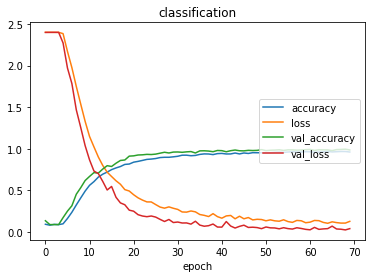

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('classification')
plt.xlabel('epoch')
plt.legend(loc = 'center right')
plt.show()

# 테스트

In [ ]:
import pandas as pd

In [ ]:
basePath = '/content/drive/MyDrive/Colab Notebooks/dacon_수화이미지분류/'

In [ ]:
test_dir = basePath + "user_data/test"
test_dir = pathlib.Path(test_dir)

In [ ]:
batch_size = 64
img_height = 96
img_width = 96

In [ ]:
image_count = len(list(test_dir.glob('*/*.png')))
print(image_count)

0


In [ ]:
class_names = os.listdir(basePath + "data_train_class")
class_names.sort()
class_names

['1', '10-1', '10-2', '2', '3', '4', '5', '6', '7', '8', '9']

In [ ]:
imageList = list(test_dir.glob('*/*.png'))
# print(imageList)

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels = None,
    seed = 123,
    shuffle = False,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 215 files belonging to 1 classes.


In [ ]:
test_df = pd.read_csv(basePath + 'user_data/test.csv')
test_df.head()

,file_name
0,001.png
1,002.png
2,003.png
3,004.png
4,005.png


In [ ]:
model = load_model(basePath + 'model_0517v5.h5')

In [ ]:
test_list = model.predict(test_ds)

In [ ]:
accuracy_list = []

for i in range(len(test_list)):
    id = np.argmax(test_list[i])
    accuracy_list.append(id)

In [ ]:
accuracy_list2 = accuracy_list.copy()

accuracy_list3 = []
for i in range(len(accuracy_list2)):
  accuracy_list3.append(class_names[accuracy_list[i]])

In [ ]:
accuracy_df = pd.DataFrame(accuracy_list3, columns = ['label']) # 데이터프레임으로 변환
class_df = pd.concat([test_df, accuracy_df], axis = 1)

In [ ]:
class_df.head(10)

,file_name,label
0,001.png,1
1,002.png,2
2,003.png,1
3,004.png,7
4,005.png,8
5,006.png,10-1
6,007.png,2
7,008.png,2
8,009.png,4
9,010.png,4


In [ ]:
class_df.reset_index(drop = True)

,file_name,label
0,001.png,7
1,002.png,7
2,003.png,7
3,004.png,7
4,005.png,7
...,...,...
210,211.png,7
211,212.png,7
212,213.png,7
213,214.png,7


In [ ]:
class_df.to_csv(basePath + "test_220517_5.csv", index = False, mode = 'w')